# Imports

In [19]:
import json
import requests

from datetime import datetime, timedelta, timezone

import pandas as pd
import numpy as np
from geopy.distance import distance

import math
import pprint
import time

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from typing import List, Union
#import pickle
#import sys

# Query GraphQL

In [20]:
def query_graphql(start_time: int, end_time: int, route: str) -> list:
    query = f"""{{
        trynState(agency: "muni",
                  startTime: "{start_time}",
                  endTime: "{end_time}",
                  routes: ["{route}"]) {{
            agency
            startTime
            routes {{
                stops {{
                    sid
                    lat
                    lon
                }}
                routeStates {{
                    vtime
                    vehicles {{
                        vid
                        lat
                        lon
                        did
                    }}
                }}
            }}
        }}
    }}
    """
    query_url = f"https://06o8rkohub.execute-api.us-west-2.amazonaws.com/dev/graphql?query={query}"

    request = requests.get(query_url).json()
    try:
        return request['data']['trynState']['routes']
    except KeyError:
        return None

# Produce Datatables

In [21]:
def produce_stops(data: list, route: str) -> pd.DataFrame:
    stops = pd.io.json.json_normalize(data,
                                      record_path=['stops']) \
            .rename(columns={'lat': 'LAT',
                             'lon': 'LON',
                             'sid': 'SID'}) \
            .reindex(['SID', 'LAT', 'LON'], axis='columns')
    
    # obtain stop directions
    stops['DID'] = stops['SID'].map({stop: direction['id']
                                     for direction in requests
                                                      .get(f"http://restbus.info/api/agencies/sf-muni/routes/{route}")
                                                      .json()['directions']
                                     for stop in direction['stops']})
    
    # remove stops that don't have an associated direction
    stops = stops.dropna(axis='index', subset=['DID'])
    
    # obtain stop ordinals
    stops['ORD'] = stops['SID'].map({stop_meta['id']: ordinal
                                     for ordinal, stop_meta
                                     in enumerate(requests
                                                  .get("http://restbus.info/api/agencies/sf-muni/"
                                                       f"routes/{route}")
                                                  .json()['stops'])})
    
    return stops

In [22]:
def produce_buses(data: list) -> pd.DataFrame:
     return pd.io.json.json_normalize(data,
                                      record_path=['routeStates', 'vehicles'],
                                      meta=[['routeStates', 'vtime']]) \
            .rename(columns={'lat': 'LAT',
                             'lon': 'LON',
                             'vid': 'VID',
                             'did': 'DID',
                             'routeStates.vtime': 'TIME'}) \
            .reindex(['TIME', 'VID', 'LAT', 'LON', 'DID'], axis='columns')

# Define Route

it took 0.2528829574584961 seconds to open and define route


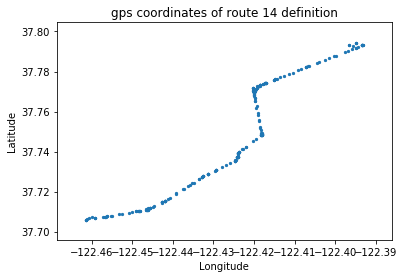

In [23]:
def routedef(routename: str) -> pd.DataFrame:
    
    with open('muniroutes_geo.json') as json_data:
        data = json.load(json_data)
        data = data['features']
        
        # collect coordinates for certain route, if route number matches given routename ex)'name'=:'14'
        routedata = [routedata['geometry']['coordinates'] \
                       for routedata in data \
                       if (routedata['properties']['name'] == routename)]
        routedata = routedata[0]
        
        routecoords = []
        for coordlist in routedata:
            for coord in coordlist:
                routecoords.append(coord)
        
        
        #get coordinates of stops for the route
        tx = time.time()
        stopsdata = requests.get(f"http://restbus.info/api/agencies/sf-muni/routes/{routename}").json()['stops']
        
        stopcoords = []
        for stop in stopsdata:
            stopcoords.append([stop['lon'],stop['lat']])
        
        # add stop coordinates to route coordnates
        for stop in stopcoords:
            # check if repeating coordinate
            if stop not in routecoords:
                routecoords.append(stop)

        routecoords = pd.DataFrame(routecoords, columns = ['LON','LAT'])
        return routecoords

t1=time.time()
routecoords = routedef('14')
print('it took %s seconds to open and define route'%(time.time()-t1))

plt.title('gps coordinates of route 14 definition')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter(routecoords['LON'],routecoords['LAT'], s = 5)
plt.show()



# Eclipses

In [24]:

# haversine formula for calcuating distance between two coordinates in lat lon
# from bird eye view; seems to be +- 8 meters difference from geopy distance
def haver_distance(latstop,lonstop,latbus,lonbus):

    latstop,lonstop,latbus,lonbus = map(np.deg2rad,[latstop,lonstop,latbus,lonbus])
    eradius = 6371000
    
    latdiff = (latbus-latstop)
    londiff = (lonbus-lonstop)
    
    a = np.sin(latdiff/2)**2 + np.cos(latstop)*np.cos(latbus)*np.sin(londiff/2)**2
    c = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    
    distance = eradius*c
    return distance
    
def find_eclipses(buses, stop):
    """
    Find movement of buses relative to the stop, in distance as a function of time.
    """
    def split_eclipses(eclipses, threshold=30*60*1000) -> List[pd.DataFrame]:
        """
        Split buses' movements when they return to a stop after completing the route.
        """
        disjoint_eclipses = []
        for bus_id in eclipses['VID'].unique(): # list of unique VID's
            # obtain distance data for this one bus
            bus = eclipses[eclipses['VID'] == bus_id].sort_values('TIME')
            #pprint.pprint(bus)
            #pprint.pprint(bus['TIME'].shift())
            #pprint.pprint(bus['TIME'].shift() + threshold)
            #print('===============')
            # split data into groups when there is at least a `threshold`-ms gap between data points
            group_ids = (bus['TIME'] > (bus['TIME'].shift() + threshold)).cumsum()

            # store groups
            for _, group in bus.groupby(group_ids):
                disjoint_eclipses.append(group)
        return disjoint_eclipses

    eclipses = buses.copy()
    #eclipses['DIST'] = eclipses.apply(lambda row: distance(stop[['LAT','LON']],row[['LAT','LON']]).meters,axis=1)
    
    stopcoord = stop[['LAT', 'LON']]
    buscoord = eclipses[['LAT', 'LON']]

    # calculate distances fast with haversine function 
    eclipses['DIST'] = haver_distance(stopcoord['LAT'],stopcoord['LON'],buscoord['LAT'],buscoord['LON'])
    # only keep positions within 750 meters within the given stop; (filtering out)
    eclipses = eclipses[eclipses['DIST'] < 750]
    
    # update the coordinates list 
    stopcoord = stop[['LAT', 'LON']].values
    buscoord = eclipses[['LAT', 'LON']].values
    
    # calculate distances again using geopy for the distance<750m values, because geopy is probably more accurate
    dfromstop = []
    for row in buscoord:
        busdistance = distance(stopcoord,row).meters
        dfromstop.append(busdistance)
    eclipses['DIST'] = dfromstop
    
    # for haversine function:
    #stopcord = stop[['LAT', 'LON']]
    #buscord = eclipses[['LAT', 'LON']]
    #eclipses['DIST'] = haver_distance(stopcord['LAT'],stopcord['LON'],buscord['LAT'],buscord['LON'])
    
    eclipses['TIME'] = eclipses['TIME'].astype(np.int64)
    eclipses = eclipses[['TIME', 'VID', 'DIST']]
    
    eclipses = split_eclipses(eclipses)
    
    return eclipses

def find_nadirs(eclipses):
    """
    Find points where buses are considered to have encountered the stop.
    
    Nadir is an astronomical term that describes the lowest point reached by an orbiting body.
    """
    def calc_nadir(eclipse: pd.DataFrame) -> Union[pd.Series, None]:
        nadir = eclipse.iloc[eclipse['DIST'].values.argmin()]
        if nadir['DIST'] < 100:  # if min dist < 100, then reasonable candidate for nadir
            return nadir
        else:  # otherwise, hardcore datasci is needed
            rev_eclipse = eclipse.iloc[::-1]
            rev_nadir = rev_eclipse.iloc[rev_eclipse['DIST'].values.argmin()]
            if nadir['TIME'] == rev_nadir['TIME']:  # if eclipse has a global min
                return nadir  # then it's the best candidate for nadir
            else:  # if eclipse's min occurs at two times
                mid_nadir = nadir.copy()
                mid_nadir['DIST'] = (nadir['DIST'] + rev_nadir['DIST'])/2
                return mid_nadir  # take the midpoint of earliest and latest mins
    
    nadirs = []
    for eclipse in eclipses:
        nadirs.append(calc_nadir(eclipse)[['VID', 'TIME']])
        
    return pd.DataFrame(nadirs)
            
    
def show_stop(eclipses, nadirs):
    fig = plt.figure(figsize=(18, 9))
    ax = fig.add_subplot(111)

    for eclipse in eclipses:
        plt.plot(*eclipse[['TIME', 'DIST']].values.T)
        
    for nadir_time in nadirs['TIME']:
        plt.axvline(nadir_time, linestyle='--', linewidth=.5)

    # format plot
    ax.get_xaxis().set_major_formatter(  # convert x-axis tick labels to time of day
        FuncFormatter(lambda x, p: datetime.fromtimestamp(int(x)//1000).strftime('%I:%M%p')))
    plt.title(f"Eclipses at Stop {stop_id}"
              f" from {datetime.fromtimestamp(int(start_time)//1000).strftime('%a %b %d %I:%M%p')}"
              f" to {datetime.fromtimestamp(int(end_time)//1000).strftime('%a %b %d %I:%M%p')}")
    plt.xlabel("Time")
    plt.ylabel("Distance from Stop (meters)")

    plt.show()

# Hardcore Data Science

In [25]:
route = ["12", "14"]

#timespan = ("08:00",
#            "11:00")

timespan = ("08:00",
            "09:00")

dates = [
    "2018-11-12",
    "2018-11-13",
    "2018-11-14",
    "2018-11-15",
    "2018-11-16",
]

Issue: The plot is labeled based on the machine's current timezone, which may not necessarily match the times sent to the API. To remedy this, the logic for displaying the plot would have to be adjusted to account for the UTC offset of the epochs we get back from the API, which I'm hoping there's a module for but I'm not presently familiar with any.

Issue: currently, if a trajectory looks like `/~V`, the left edge is selected as the nadir. Based on the data, I suspect that the initial upslope may be a GPS glitch as it's being initialized, I believe the trough on the right should be selected instead.

In [26]:
class BusData:
    def __init__(self):
        self.data = {}
    
    @property
    def routes(self):
        return list(self.data.keys())
    
    @property
    def stops(self, route_id):
        return list(self.data.get(route_id, {}).keys())
    
    def append(self, other_data):
        for route_id, other_route in other_data.items():
            route = self.data.get(route_id)
            if route:
                for stop_id, other_stop in other_route.items():
                    stop = route.get(stop_id)
                    if stop:
                        stop['eclipses'].extend(other_stop['eclipses'])
                    else:
                        route[stop_id] = other_stop
            else:
                self.data[route_id] = other_route
    
    @classmethod
    def read_file(cls, filename):
        bus_data = cls()
        with open(filename, 'r') as f:
            bus_data.append(json.load(f))
        return bus_data
                
    
    def write_file(self, filename):
        with open(filename, 'w') as f:
            json.dump(self.data, f)

`BusData.data` specification:
```
{
    route_id: {  # route_id is a str
        stop_id: {  # stop_id is a str
            direction_id: str,
            order: int,
            lat: float,
            lon: float,
            eclipses: [
                {
                    bus_id: int,
                    timestamp: int,
                },
                {
                    bus_id: int,
                    timestamp: int,
                },
                ...
            ]
        },
        ...
    },
    ...
}
```

In [27]:
# get_stops
# ------------------------------------------------------------------------------------------
# parameters:
# dates: an array of dates, formatted as strings in the form YYYY-MM-DD
# routes: an array of routes, each represented as a string
# directions: an array of strings representing the directions to filter
# stops: an array of strings representing the stops to filter
# times: a tuple with the start and end times (in UTC -8:00) as strings in the form HH:MM 
# 
# returns:
# stops: a DataFrame, filtered by the given directions and stops, with the following columns:
# VID: the vehicle ID
# Time: a datetime object representing the date/time of the stop
# Route: the route on which the stop occurred
# Stop: the stop at which the stop occurred
# Dir: the direction in which the stop occurred
# -------------------------------------------------------------------------------------------
def get_stops(dates, routes, directions = [], new_stops = [], times = ("00:00", "23:59")):
    bus_stops = pd.DataFrame(columns = ["VID", "TIME", "SID", "DID", "ROUTE"])
    
    for route in routes:
        stop_ids = [stop['id']
            for stop
            in requests.get(f"http://restbus.info/api/agencies/sf-muni/routes/{route}").json()['stops']][2:4]
        for stop_id in stop_ids:
            # check if stops to filter were provided, or if the stop_id is in the list of filtered stops
            if (stop_id in new_stops) ^ (len(new_stops) == 0):
                for date in dates:
                    print(f"{datetime.now().strftime('%a %b %d %I:%M:%S %p')}: starting processing on stop {stop_id} on route {route} on {date}.")
                    start_time = int(datetime.strptime(f"{date} {timespan[0]} -0800", "%Y-%m-%d %H:%M %z").timestamp())*1000
                    end_time   = int(datetime.strptime(f"{date} {timespan[1]} -0800", "%Y-%m-%d %H:%M %z").timestamp())*1000

                    data = query_graphql(start_time, end_time, route)
                    print(f"{datetime.now().strftime('%a %b %d %I:%M:%S %p')}: performed query.")

                    if data is None:  # API might refuse to cooperate
                        print("API probably timed out")
                        continue
                    elif len(data) == 0:  # some days somehow have no data
                        print(f"no data for {month}/{day}")
                        continue
                    else:
                        stops = produce_stops(data, route)
                        print(f"{datetime.now().strftime('%a %b %d %I:%M:%S %p')}: produced stops.")
                        
                        #pprint.pprint(data)
                        buses = produce_buses(data)
                        #pprint.pprint(buses)
                        
                        #mydict_as_string = pickle.dumps(data)
                        #print(sys.getsizeof(mydict_as_string))
                        
                        print(f"{datetime.now().strftime('%a %b %d %I:%M:%S %p')}: produced buses.")
                        
                        # select single stop that match stop_id
                        stop = stops[stops['SID'] == stop_id].squeeze()
                        # select buses that have matching DID with the stop
                        buses = buses[buses['DID'] == stop['DID']]
                              
                        plt.title('gps coordinates of buses')
                        plt.xlabel('Longitude')
                        plt.ylabel('Latitude')
                        plt.scatter(buses['LON'],buses['LAT'], s = 5)
                        plt.show()
                              
                        plt.title('gps coordinates of stops')
                        plt.xlabel('Longitude')
                        plt.ylabel('Latitude')
                        plt.scatter(stops['LON'],stops['LAT'],c='r', s = 5)
                        plt.show()
                        
                        starttime = time.time()
                        eclipses = find_eclipses(buses, stop)
                        print('time elapsed for eclipse function: %s' % (time.time() - starttime))
                              
                        print(f"{datetime.now().strftime('%a %b %d %I:%M:%S %p')}: found eclipses.")
                              
                        nadirs = find_nadirs(eclipses)
                        print(f"{datetime.now().strftime('%a %b %d %I:%M:%S %p')}: found nadirs.")
                            
                        nadirs["TIME"] = nadirs["TIME"].apply(lambda x: datetime.fromtimestamp(x//1000, timezone(timedelta(hours = -8))).strftime('%a %b %d %Y %I:%M%p'))
                        nadirs["SID"] = stop_id
                        nadirs["DID"] = stop["DID"]
                        nadirs["ROUTE"] = route
                        old_length = len(bus_stops)
                        bus_stops = bus_stops.append(nadirs, sort = True)
                        print(f"{datetime.now().strftime('%a %b %d %I:%M:%S %p')}: finished processing.")

    # filter for directions
    if len(directions) > 0:
        bus_stops = bus_stops.loc[bus_stops['DID'].apply(lambda x: x in directions)]
    
    return bus_stops

Wed Feb 06 07:06:53 PM: starting processing on stop 5528 on route 14 on 2018-11-12.
Wed Feb 06 07:06:58 PM: performed query.
Wed Feb 06 07:06:59 PM: produced stops.
Wed Feb 06 07:06:59 PM: produced buses.


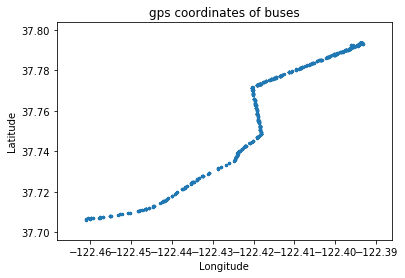

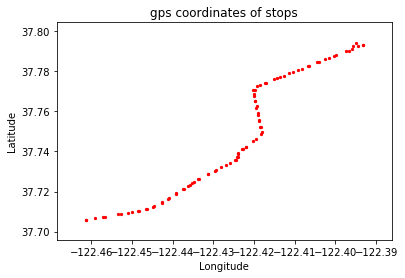

time elapsed for eclipse function: 0.17942094802856445
Wed Feb 06 07:07:00 PM: found eclipses.
Wed Feb 06 07:07:00 PM: found nadirs.
Wed Feb 06 07:07:00 PM: finished processing.
Wed Feb 06 07:07:00 PM: starting processing on stop 5528 on route 14 on 2018-11-13.
Wed Feb 06 07:07:04 PM: performed query.
Wed Feb 06 07:07:05 PM: produced stops.
Wed Feb 06 07:07:05 PM: produced buses.


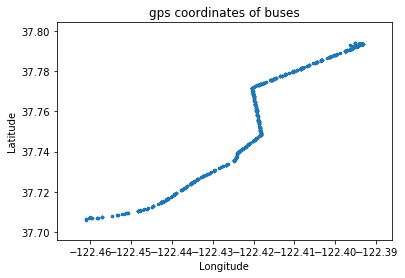

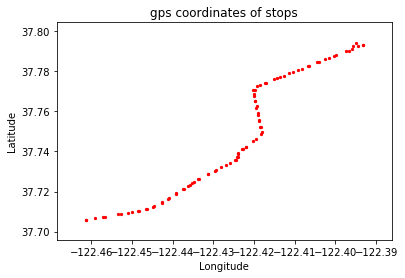

time elapsed for eclipse function: 0.24041414260864258
Wed Feb 06 07:07:06 PM: found eclipses.
Wed Feb 06 07:07:06 PM: found nadirs.
Wed Feb 06 07:07:06 PM: finished processing.
Wed Feb 06 07:07:06 PM: starting processing on stop 5528 on route 14 on 2018-11-14.
Wed Feb 06 07:07:10 PM: performed query.
Wed Feb 06 07:07:11 PM: produced stops.
Wed Feb 06 07:07:11 PM: produced buses.


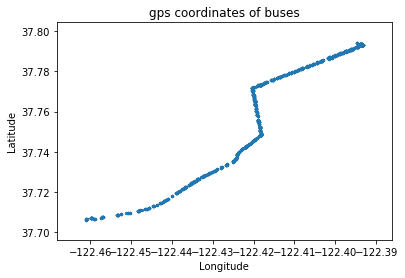

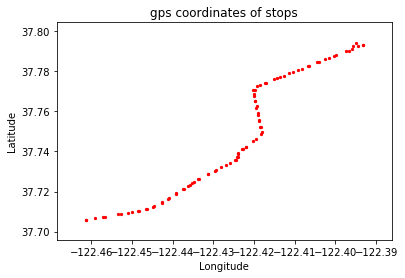

time elapsed for eclipse function: 0.20522499084472656
Wed Feb 06 07:07:11 PM: found eclipses.
Wed Feb 06 07:07:11 PM: found nadirs.
Wed Feb 06 07:07:11 PM: finished processing.
Wed Feb 06 07:07:11 PM: starting processing on stop 5528 on route 14 on 2018-11-15.
Wed Feb 06 07:07:17 PM: performed query.
Wed Feb 06 07:07:17 PM: produced stops.
Wed Feb 06 07:07:17 PM: produced buses.


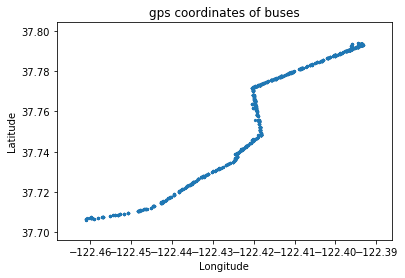

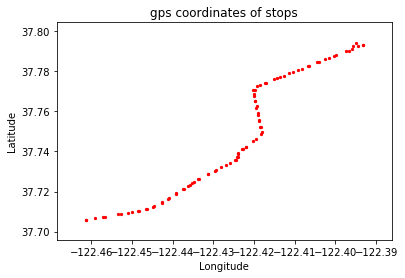

time elapsed for eclipse function: 0.21865320205688477
Wed Feb 06 07:07:18 PM: found eclipses.
Wed Feb 06 07:07:18 PM: found nadirs.
Wed Feb 06 07:07:18 PM: finished processing.
Wed Feb 06 07:07:18 PM: starting processing on stop 5528 on route 14 on 2018-11-16.
Wed Feb 06 07:07:22 PM: performed query.
Wed Feb 06 07:07:23 PM: produced stops.
Wed Feb 06 07:07:23 PM: produced buses.


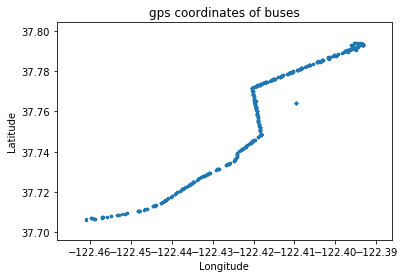

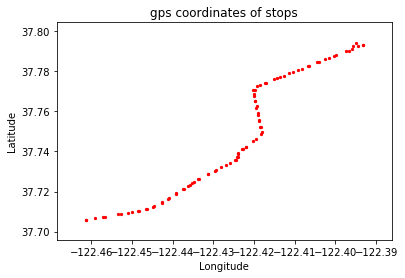

time elapsed for eclipse function: 0.2399120330810547
Wed Feb 06 07:07:24 PM: found eclipses.
Wed Feb 06 07:07:24 PM: found nadirs.
Wed Feb 06 07:07:24 PM: finished processing.


In [28]:
new_stops = get_stops(dates, route, directions = ['14___O_F00'], new_stops = ['5528'], times = timespan)

In [29]:
# TODO: parse direction as inbound/outbound? (remove route indicator)
# filter by direction/stop if provided
# split date/time
new_stops

,DID,ROUTE,SID,TIME,VID
254,14___O_F00,14,5528,Mon Nov 12 2018 08:03AM,7225
974,14___O_F00,14,5528,Mon Nov 12 2018 08:14AM,7254
1460,14___O_F00,14,5528,Mon Nov 12 2018 08:21AM,7244
2107,14___O_F00,14,5528,Mon Nov 12 2018 08:30AM,7272
3342,14___O_F00,14,5528,Mon Nov 12 2018 08:49AM,7232
3658,14___O_F00,14,5528,Mon Nov 12 2018 08:54AM,7229
2569,14___O_F00,14,5528,Mon Nov 12 2018 08:37AM,7220
4122,14___O_F00,14,5528,Mon Nov 12 2018 09:00AM,7283
3908,14___O_F00,14,5528,Mon Nov 12 2018 08:57AM,7261
882,14___O_F00,14,5528,Tue Nov 13 2018 08:12AM,7220


In [30]:
new_stops['DID'].unique()

array(['14___O_F00'], dtype=object)

In [31]:
new_stops['SID'].unique()

array(['5528'], dtype=object)

In [32]:
def average_waiting_time(df, start_time, end_time):
    minute_range = [start_time.replace(minute = start_time.minute + i) for i in range(end_time.minute - start_time.minute)]
    wait_times = pd.DataFrame(columns = ["ROUTE", "TIME", "WAIT"])
    
    for minute in minute_range:
        print("hi")

In [33]:
new_stops["timestamp"] = new_stops["TIME"].apply(lambda x: datetime.strptime(x, '%a %b %d %Y %I:%M%p').timestamp())

In [34]:
new_stops['date'] = new_stops["TIME"].apply(lambda x: datetime.strptime(x, '%a %b %d %Y %I:%M%p').date())

In [35]:
pivot = new_stops[['date', 'timestamp']].pivot_table(values = ['timestamp'], index = ['date'])

In [36]:
pivot['timestamp'] = pivot['timestamp'].apply(lambda x: )

SyntaxError: invalid syntax (<ipython-input-36-f1e297e488d5>, line 1)